# Specing the Controller

## Application
I have a custom, high performance [3D printer](https://photos.app.goo.gl/rBneLEBik97HPc837) which right now uses stepper motors to power the XY gantry. While they are preformant enough for pretty high-speed printing, I would like to have something with more reliability and repeatability (and more power would be nice too :D).

The NEMA17 steppers I have right now are the [LDO-42STH48-2504AC](https://ratrig.com/nema-17-stepper-motor.html) driver by [Trinamic TMC2209s](https://www.trinamic.com/products/integrated-circuits/details/tmc2209-la/) which is basically the top of the line for 3D printer power systems. Two of them are used to drive the printer's coreXY gantry.

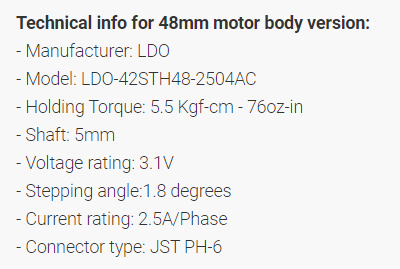

One way I thought of improving on this was by upgrading to a BLDC architecture. In order to meet my goals of power and accuracy this would require:
1. A BLDC motor that has better specs than the LDOs
2. A power system to supply the motors
3. A BLDC driver to drive the motors
4. An encoder to read the position of the BLDC motor and correct for positing errors

#### Motor
The motor selection was pretty easy because I could use that I had on hand. When they were on a massive sale I bought a bunch of [Turnigy Aerodrive SK3 - 4250-350KV](https://hobbyking.com/en_us/turnigy-aerodrive-sk3-4250-350kv-brushless-outrunner-motor.html) and [Turnigy Aerodrive SK3 - 5065-275KV](https://hobbyking.com/en_us/turnigy-aerodrive-sk3-5065-275kv-brushless-outrunner-motor.html) motors. These are commonly used in the BLDC motor community as NEMA17 and NEMA23 stepper replacements so they should be suited for my application. I'll go more into the power requirements for my desired torque later.

#### Power System
Since this is going on a 3D printer it can't source hundreds of amps from a lipo. Instead, I have to use power supplies and spec my system accordingly. There is also a total input power limit I cannot exceed which is the maximum amount of power I can draw from an AC power plug. This is at least 15A at 110V (1650W) according to [NEC Table 240.6(A)](https://www.electricallicenserenewal.com/Electrical-Continuing-Education-Courses/NEC-Content.php?sectionID=253.0).

Since the printer bed draws 1000W peak I have around 650W for everything else so I would ideally like to keep the peak power draw of the controller under 500W. This is pretty doable with COTS power supplies.

### Motor Controller
The motor controller is the main part I will be designing. A couple important features for me are:
* Be able to drive at least the 4250-350KV (5065-275KV would be nice but optional since its so big)
* Easy to interface with (UART and step direction interface preferred)
* Compact size to fit near motor (I don"t have a ton of space on the back of the printer)
* Field Oriented Control for maximum torque output (lol)
* More precision than a 1.8deg NEMA17 (See encoder calculations section)

### Encoder
The encoder is relatively simple, I may add more to it later but its most likely going to be a breakout PCB for the [AS5047D](https://ams.com/en/as5047d) which is an AMS mag encoder chip that I can read as a quadrature encoder. See more in the encoder section for resolution/speed calculations.

## Calculations
Now that we know our motors and some basic info about out power setup, we can start calculating the design requirements for our controller.

### Turnigy Aerodrive SK3 - 4250-350KV
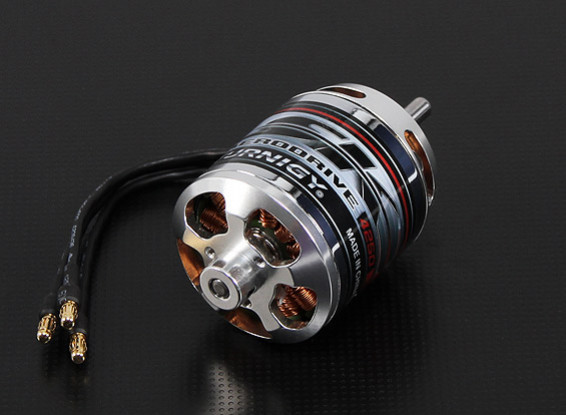

Once you have your motor, the first thing you want to do is dump all the spec sheets from the website into once place. For some reason Turnigy can"t make one table will all the specs on it so we get to go between the two.

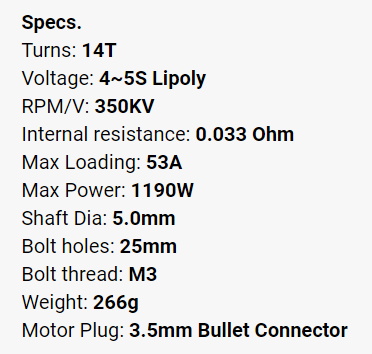

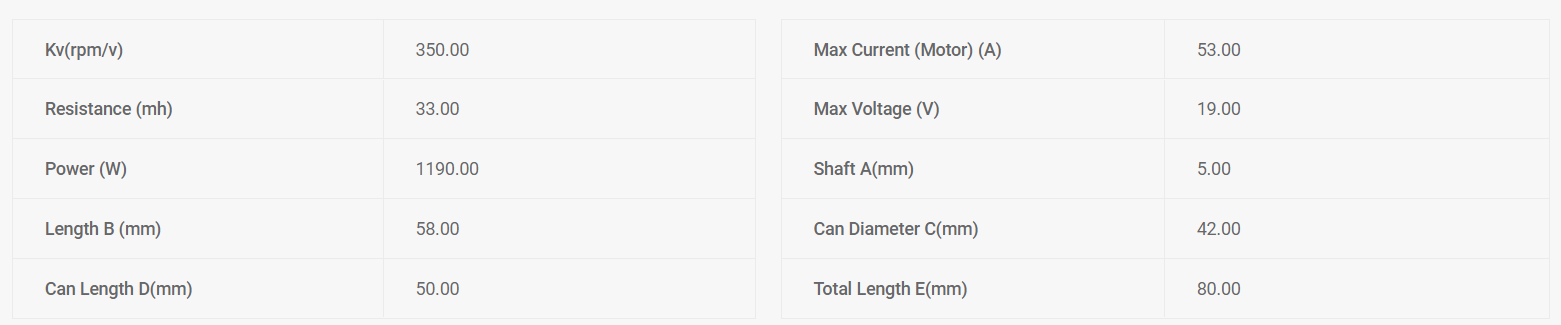

[ODrive Motor Guide](https://docs.google.com/spreadsheets/d/12vzz7XVEK6YNIOqH0jAz51F5VUpc-lJEs3mmkWP1H4Y/edit#gid=0)

When I see these tables, the key things I am looking for are max voltage + max RPM (or Kv) and max current + max torque (or Kt). Knowing Kv and Kt for the motor (assuming linearity) will let us to draw up some simple motor curves to drive our calculations.

For the 4250-350kV I took the specs from the ODrive Motor Guide because it has empirical data: \
$\omega_{max} = 7000RPM$ \
$V_{max} = 20V$ \
$\tau_{max} = 1.18Nm$ \
$I_{max} = 50A$

So,
$$Kv = \frac{7000RPM}{20V} = 350\frac{RPM}{V}$$
$$Kt = \frac{1.18Nm}{50A} = 0.0236\frac{Nm}{A}$$

The motor curve becomes:

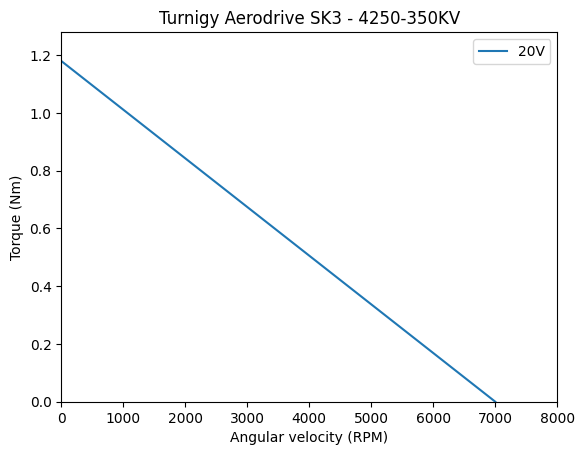

In [39]:
# %%
%matplotlib inline
import matplotlib.pyplot as plt

voltage_max = 20 # V
omega_max = 7000 # RPM (20V)
torque_max = 1.18 # Nm (20V)

motor_name = "Turnigy Aerodrive SK3 - 4250-350KV"

fig, ax = plt.subplots()

# Plot original motor curve
ax.set_xlim(0, omega_max + 1000)
ax.set_ylim(0, torque_max + 0.1)

ax.set_xlabel("Angular velocity (RPM)")
ax.set_ylabel("Torque (Nm)")

ax.set_title(motor_name)

ax.plot([0, omega_max], [torque_max, 0], label="{}V".format(voltage_max))

ax.legend()

The max drive voltage for this motor is 19-20V but I can't really get a  high current, reliable power supply in that range. Instead, the most common voltages are 12V and 24V.

If we derate this curve to 12V:

Derated max angular velocity: 4200.000 RPM
Derated max torque: 0.708 Nm


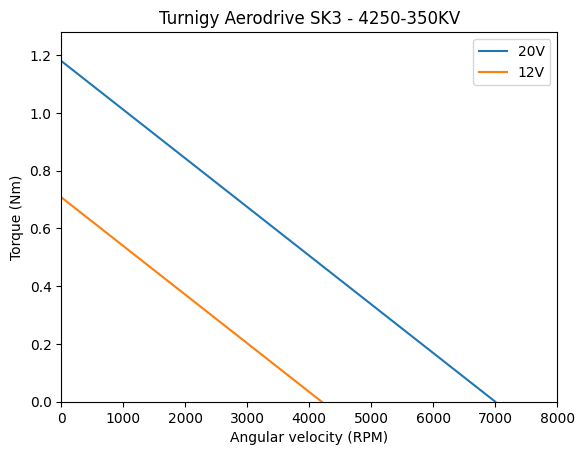

In [40]:
# %%
%matplotlib inline

derating_voltage = 12 # V

# Plot derated motor curve
# derating_voltage / voltage_max = spec / spec_max
derating_factor = derating_voltage / voltage_max

derated_omega_max = omega_max * derating_factor
derated_torque_max = torque_max * derating_factor

ax.plot([0, derated_omega_max], [derated_torque_max, 0], label="{}V".format(derating_voltage))
ax.legend()

print("Derated max angular velocity: {:.3f} RPM".format(derated_omega_max))
print("Derated max torque: {:.3f} Nm".format(derated_torque_max))

fig

We can see that even at 12V the motor has a stall torque output significantly larger than the LDO NEMA17. The max RPM is also much higher than what a stepper motor can achieve with a reasonable amount of microstepping and 24V.

I was generally pretty satisfied with this as its it pretty easy to source high current 12V supplies (thanks to the LED lighting community) and the motor should be pretty performant at that lower voltage. We can calculate the max current the derated motor will draw using Kt:
$$I_{max} = \frac{\tau_{max}}{Kt}$$
$$I_{max} = \frac{0.708Nm}{0.0236\frac{Nm}{A}}$$
$$I_{max} = 30A$$

And power,
$$P = I \cdot V$$
$$P = 30A * 12V$$
$$P = 360W$$

So we know our controller needs to handle at least $12V$ at $30A$.

### Turnigy Aerodrive SK3 - 5065-275KV
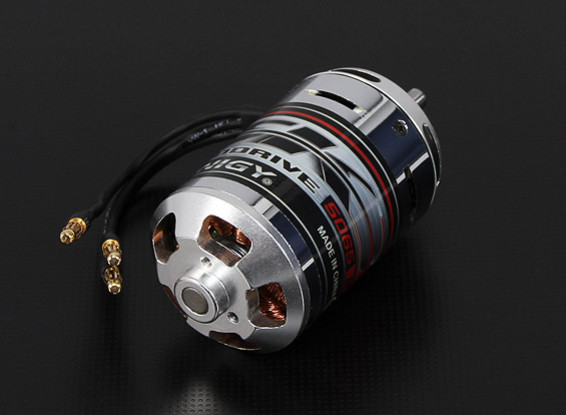

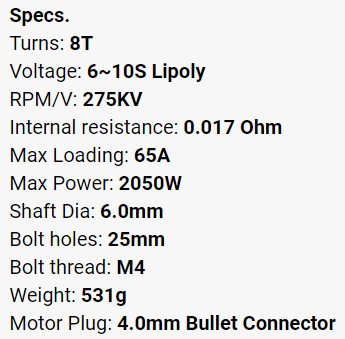

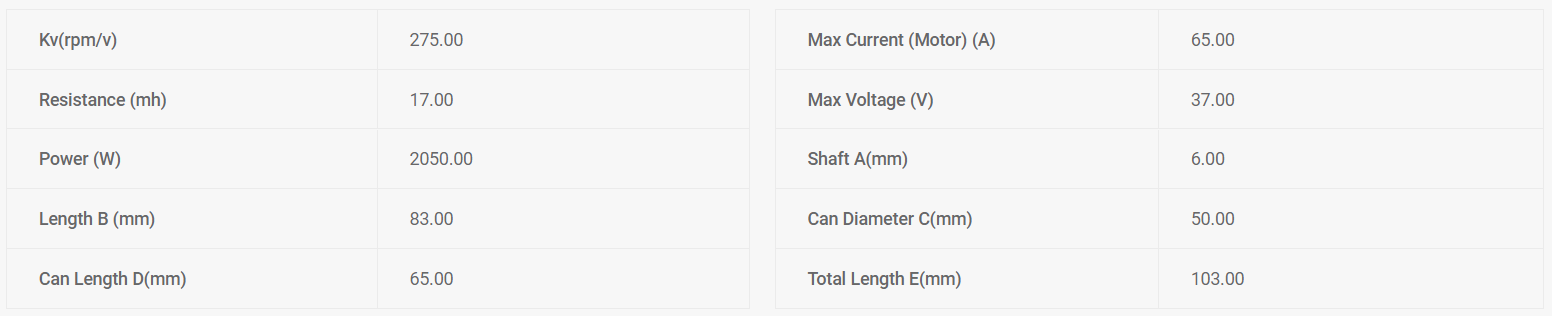

[ODrive Motor Guide](https://docs.google.com/spreadsheets/d/12vzz7XVEK6YNIOqH0jAz51F5VUpc-lJEs3mmkWP1H4Y/edit#gid=0)

Specs:
$\omega_{max} = 10560RPM$ \
$V_{max} = 40V$ \
$\tau_{max} = 1.80Nm$ \
$I_{max} = 60A$

So,
$$Kv = \frac{10560RPM}{40V} = 264\frac{RPM}{V}$$
$$Kt = \frac{1.80Nm}{60A} = 0.03\frac{Nm}{A}$$

Note: The Kv discrepancy here is because I used the emperical ODrive Motor Guide data.

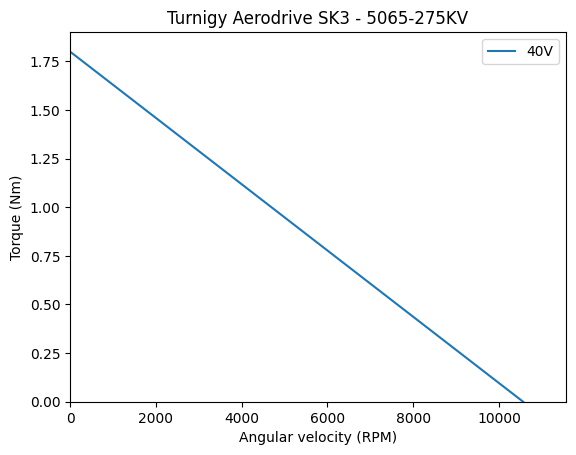

In [45]:
# %%
%matplotlib inline
import matplotlib.pyplot as plt

voltage_max = 40 # V
omega_max = 10560 # RPM (20V)
torque_max = 1.80 # Nm (20V)
motor_name = "Turnigy Aerodrive SK3 - 5065-275KV"

fig, ax = plt.subplots()

# Plot original motor curve
ax.set_xlim(0, omega_max + 1000)
ax.set_ylim(0, torque_max + 0.1)

ax.set_xlabel("Angular velocity (RPM)")
ax.set_ylabel("Torque (Nm)")

ax.set_title(motor_name)

ax.plot([0, omega_max], [torque_max, 0], label="{}V".format(voltage_max))

ax.legend()

A common power supply voltage that is above 12V but below 40V is 24V. Derating the curve:

Derated max angular velocity: 6336.000 RPM
Derated max torque: 1.080 Nm


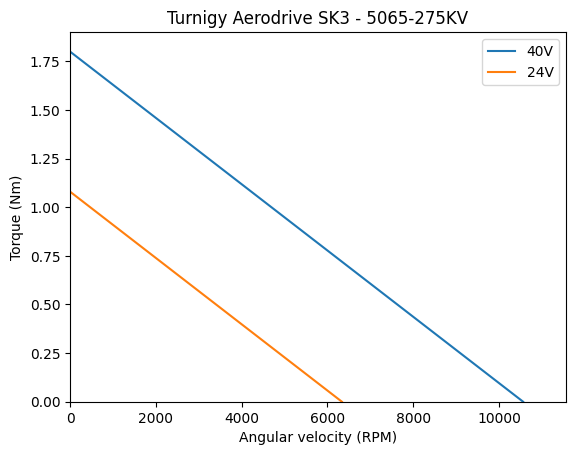

In [46]:
# %%
%matplotlib inline

derating_voltage = 24 # V

# Plot derated motor curve
# derating_voltage / voltage_max = spec / spec_max
derating_factor = derating_voltage / voltage_max

derated_omega_max = omega_max * derating_factor
derated_torque_max = torque_max * derating_factor

ax.plot([0, derated_omega_max], [derated_torque_max, 0], label="{}V".format(derating_voltage))
ax.legend()

print("Derated max angular velocity: {:.3f} RPM".format(derated_omega_max))
print("Derated max torque: {:.3f} Nm".format(derated_torque_max))

fig

This motor has significantly more torque and power than we need and is aso very big. However, still want to support it as it would be nice to test the controller on multiple motors.

The power specs are:
$$I_{max} = \frac{\tau_{max}}{Kt}$$
$$I_{max} = \frac{1.08Nm}{0.03\frac{Nm}{A}}$$
$$I_{max} = 36A$$

And power,
$$P = I \cdot V$$
$$P = 36A * 24V$$
$$P = 864W$$

Its a lot harder to find an 864W power supply, and two motors ($864W \cdot 2 = 1728W$) is more than we can draw from a plug on a 15A outlet.

But if we are supporting it we know our controller needs to handle at least $24V$ at $36A$.

## Specs
With some safety margin specs tell us that our controller will need to do up to:
$$40V \text{ @ } 60A$$
$$2,400W$$